# <span style="font-family: Arial, sans-serif; color:#97f788">Binary Classification with Softmax</span>

<span style="font-family: Arial, sans-serif; color:navyblue">Author: <a href="https://github.com/deburky" title="GitHub link">https://github.com/deburky</a></span>

A comparison of logistic regression and softmax for binary classification.

Link function: $\text{softmax}(g_j(x)) = \frac{e^{g_j(x)}}{\sum_{k=1}^{K} e^{g_k(x)}}$

where we have 2 classes, $K=2$.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Fetch blended credit data
url = (
    "https://drive.google.com/file/d/1Is8UZnPRExI-SLJMle8GRbFGpha5IvYZ/view?usp=sharing"
)
url = "https://drive.google.com/uc?id=" + url.split("/")[-2]
dataset = pd.read_csv(url, index_col=False)

features = [
    "revolving_utilization_of_unsecured_lines",
    "account_never_delinq_percent",
    "net_fraction_revolving_burden",
    "num_total_cc_accounts",
    "average_months_in_file",
    "balance",
]

target = 'is_bad'

X, y = dataset[features], dataset[target]

ix_train, ix_test = train_test_split(
    X.index, stratify=y, test_size=0.3, random_state=62
)

## Logistic and Softmax MLE
- [Relationship Between Logistic Regression and Softmax Regression with 2 Classes](https://stats.stackexchange.com/questions/299120/relationship-between-logistic-regression-and-softmax-regression-with-2-classes)
- [Softmax Regression](http://deeplearning.stanford.edu/tutorial/supervised/SoftmaxRegression/)

Selected X shape: (3000, 2)
Selected y shape: (3000,)
Logistic Regression Coefficients: -2.7008000051652012 [0.92672824 0.56584584]
Softmax Regression Coefficients:  -2.700797949226607 [0.92672719 0.5658446 ]


/Users/deburky/Library/Caches/pypoetry/virtualenvs/lr-focal-loss-Opjerf94-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


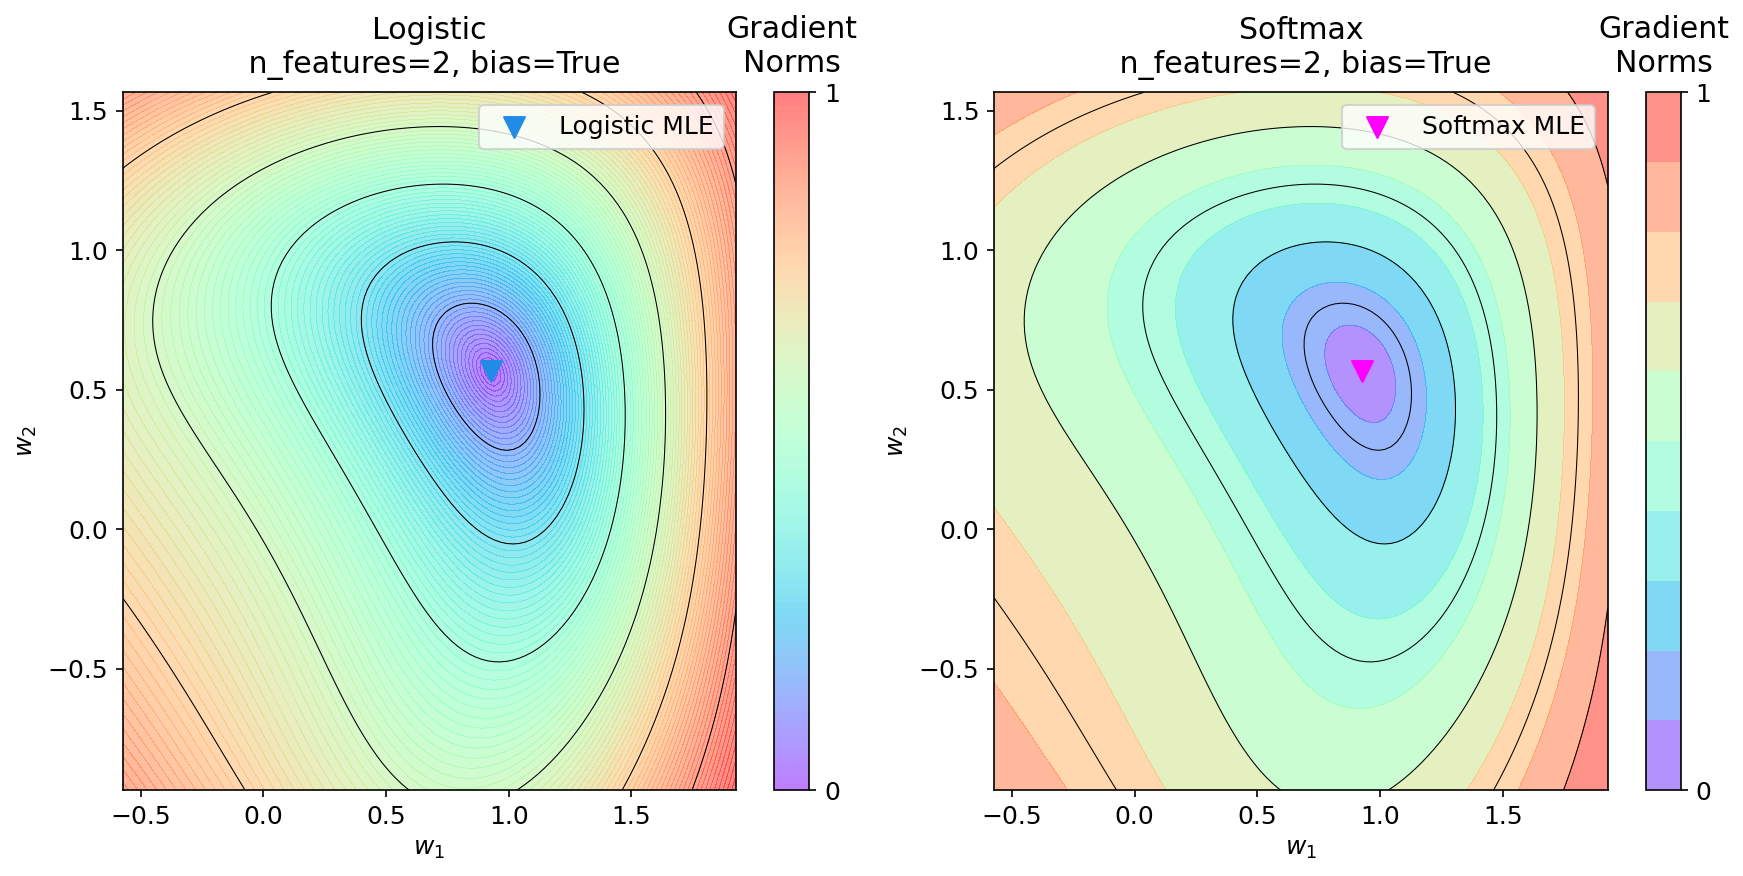

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

use_bias = True
bias_text = "bias=True" if use_bias else "bias=False"

# Function to fit logistic regression and return MLE estimates
def fit_logistic_regression(X, y):
    model = LogisticRegression(
        fit_intercept=use_bias,
        penalty=None,
        solver='newton-cg',
        max_iter=1000,
        random_state=32
    )
    model.fit(X, y)
    return model.intercept_[0], model.coef_.flatten()

def _sigmoid(x):
    sigmoid = 1 / (1 + np.exp(-x))
    return np.clip(sigmoid, 1e-15, 1 - 1e-15)

def fit_softmax_regression(X, y):
    model = LogisticRegression(
        fit_intercept=use_bias,
        penalty=None,
        solver='newton-cg',
        random_state=32,
        max_iter=1000,
        multi_class='multinomial'
    )
    model.fit(X, y)
    return model.intercept_[0], model.coef_.flatten()

# Gradient of the logistic regression log-likelihood
def _score_function(beta, X, y):
    z = np.dot(X, beta)
    p = _sigmoid(z)
    return np.dot(X.T, (y - p))

# Function to generate mesh grid for contour plotting
def generate_meshgrid(X1_range, X2_range):
    B0, B1 = np.meshgrid(X1_range, X2_range)
    return B0, B1

# Using your dataset
selected_indices = ix_test.copy()
features_to_train = ["revolving_utilization_of_unsecured_lines", "net_fraction_revolving_burden"]
X_selected = X.loc[selected_indices][features_to_train].values
y_selected = y.loc[selected_indices].values

scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

print("Selected X shape:", X_selected.shape)
print("Selected y shape:", y_selected.shape)

# Fit logistic regression model
intercept_logistic, beta_hat_logistic = fit_logistic_regression(X_selected, y_selected)
intercept_softmax, beta_hat_softmax = fit_softmax_regression(X_selected, y_selected)

# Convert 2K to sigmoid formulation
intercept_softmax = intercept_softmax - (-intercept_softmax) # same as b times 2
beta_hat_softmax = beta_hat_softmax - (-beta_hat_softmax) # same as w times 2

print("Logistic Regression Coefficients:", intercept_logistic, beta_hat_logistic)
print("Softmax Regression Coefficients: ", intercept_softmax, beta_hat_softmax)

# Ensure we have enough features
assert len(beta_hat_logistic) >= 2, "Not enough features in logistic regression coefficients"
assert len(beta_hat_softmax) >= 2, "Not enough features in softmax regression coefficients"

# Generating mesh grid for plotting (weights space)
X1_range = np.linspace(beta_hat_logistic[0] - 1.5, beta_hat_logistic[0] + 1, 100)
X2_range = np.linspace(beta_hat_logistic[1] - 1.5, beta_hat_logistic[1] + 1, 100)
B0, B1 = generate_meshgrid(X1_range, X2_range)

# Calculating gradient norms for the grid
grad_norms_logistic = np.zeros(B0.shape)
grad_norms_softmax = np.zeros(B0.shape)

for j in range(B0.shape[0]):
    for k in range(B0.shape[1]):
        if use_bias:
            weights_and_bias_logistic = np.array([intercept_logistic, B0[j, k], B1[j, k]])
            weights_and_bias_softmax = np.array([intercept_softmax, B0[j, k], B1[j, k]])
            X_mesh = np.c_[np.ones(X_selected.shape[0]), X_selected]
        else:
            weights_and_bias_logistic = np.array([B0[j, k], B1[j, k]])
            weights_and_bias_softmax = np.array([B0[j, k], B1[j, k]])
            X_mesh = X_selected
        grad_logistic = _score_function(weights_and_bias_logistic, X_mesh, y_selected)
        grad_softmax = _score_function(weights_and_bias_softmax, X_mesh, y_selected)
        grad_norms_logistic[j, k] = np.linalg.norm(grad_logistic)
        grad_norms_softmax[j, k] = np.linalg.norm(grad_softmax)

# Normalize the gradient norms for consistent visualization
grad_norms_logistic = grad_norms_logistic / grad_norms_logistic.max()
grad_norms_softmax = grad_norms_softmax / grad_norms_softmax.max()

# Plotting
plt.figure(figsize=(12, 6), dpi=150)
plt.rcParams.update({'font.size': 12})

# Contour plot for Logistic Regression
plt.subplot(1, 2, 1)
contour_logistic = plt.contourf(B0, B1, grad_norms_logistic, levels=100, cmap='rainbow', alpha=0.5)
cbar_logistic = plt.colorbar(contour_logistic)
cbar_logistic.set_ticks([])
cbar_logistic.set_ticks([0, 1])
cbar_logistic.ax.set_title('Gradient\nNorms', pad=10)
plt.contour(B0, B1, grad_norms_logistic, colors='black', linewidths=0.5)
plt.scatter(
    beta_hat_logistic[0], 
    beta_hat_logistic[1], 
    color='#228be6',
    marker='v', 
    s=100, 
    label='Logistic MLE'
)
plt.title(
    f'Logistic\n n_features=2, {bias_text}', 
    y=1.01
)
plt.xlim(B0.min(), B0.max())
plt.ylim(B1.min(), B1.max())
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')
plt.legend()

# Contour plot for Softmax Regression
plt.subplot(1, 2, 2)
contour_softmax = plt.contourf(B0, B1, grad_norms_softmax, levels=10, cmap='rainbow', alpha=0.5)
cbar_softmax = plt.colorbar(contour_softmax)
cbar_softmax.set_ticks([])
cbar_softmax.set_ticks([0, 1])
cbar_softmax.ax.set_title('Gradient\nNorms', pad=10)
plt.contour(B0, B1, grad_norms_softmax, colors='black', linewidths=0.5)
plt.scatter(
    beta_hat_softmax[0], 
    beta_hat_softmax[1], 
    color='magenta',
    marker='v',
    s=100,
    label='Softmax MLE'
)
plt.title(
    f'Softmax\n n_features=2, {bias_text}', 
    y=1.01
)
plt.xlim(B0.min(), B0.max())
plt.ylim(B1.min(), B1.max())
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')
plt.legend()

plt.tight_layout()
plt.show()